In [1]:
!pip install sounddevice


In [2]:
!pip install lightgbm

In [3]:
!pip install speechrecognition
!pip install pyaudio

In [4]:
 !pip install librosa soundfile scikit-learn xgboost tqdm

🔎 Extracting features...
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-01-01-01.wav (mean RMS: 0.0021)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-01-02-01.wav (mean RMS: 0.0023)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-02-01-01.wav (mean RMS: 0.0027)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-01-01-02-02-01.wav (mean RMS: 0.0025)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-01-01.wav (mean RMS: 0.0016)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-01-02-01.wav (mean RMS: 0.0017)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-02-01-01.wav (mean RMS: 0.0026)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Actor_01\03-01-02-01-02-02-01.wav (mean RMS: 0.0026)
⚠️ Skipping file with invalid RMS: Audio_Speech_Actors_01-24\Ac

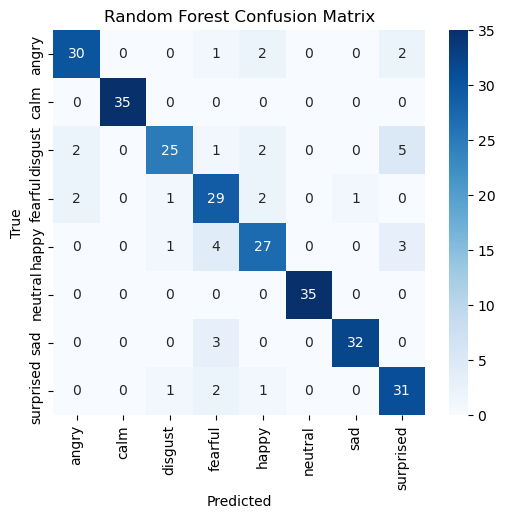


⚡ Training Logistic Regression...
Logistic Regression Accuracy: 0.89
Logistic Regression Training Time: 1.81 seconds
              precision    recall  f1-score   support

       angry       0.84      0.91      0.88        35
        calm       0.97      1.00      0.99        35
     disgust       1.00      0.86      0.92        35
     fearful       0.90      0.77      0.83        35
       happy       0.80      0.80      0.80        35
     neutral       0.95      1.00      0.97        35
         sad       0.89      0.91      0.90        35
   surprised       0.79      0.86      0.82        35

    accuracy                           0.89       280
   macro avg       0.89      0.89      0.89       280
weighted avg       0.89      0.89      0.89       280



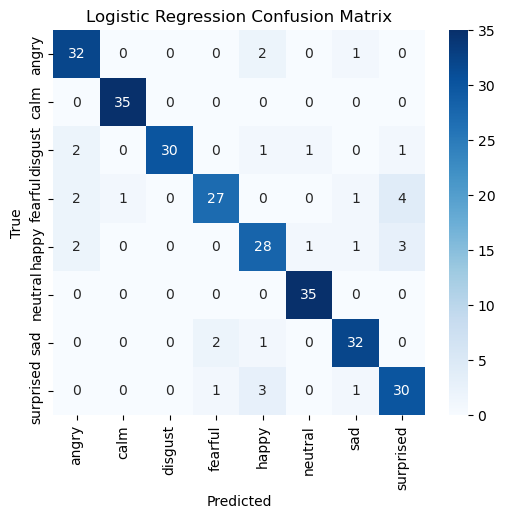


⚡ Training SVM...
SVM Accuracy: 0.88
SVM Training Time: 1.01 seconds
              precision    recall  f1-score   support

       angry       0.80      0.91      0.85        35
        calm       1.00      1.00      1.00        35
     disgust       0.90      0.77      0.83        35
     fearful       0.67      0.83      0.74        35
       happy       0.89      0.71      0.79        35
     neutral       1.00      1.00      1.00        35
         sad       0.94      0.89      0.91        35
   surprised       0.86      0.89      0.87        35

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.88       280
weighted avg       0.88      0.88      0.88       280



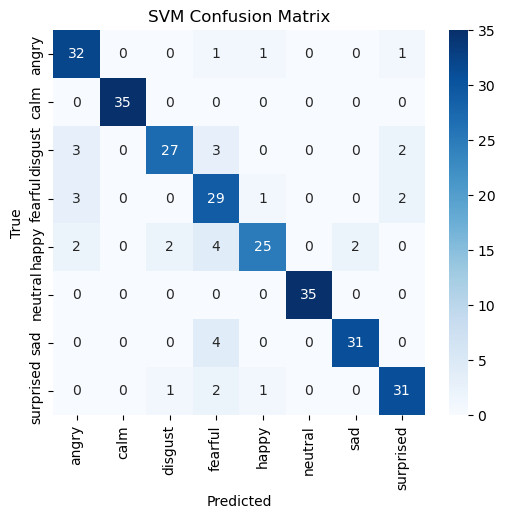


⚡ Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76803
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 302
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.91
LightGBM Training Time: 12.29 seconds
              precision    recall  f1-score   support

       angry       0.87      0.97      0.92        35
        calm       1.00      1.00      1.00        35
     disgust       0.97      0.83      0.89        35
     fearful       0.81      0.86      0.83        35
       happy       0.90      0.74      0.81        35
     neutral       1.00      1.00      1.00        35
         sad       0.94      0.94      0.94        35
   surprised       0.80      0.91      0.85        35

    accuracy                           0.91       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.91      0.91      0.91       280



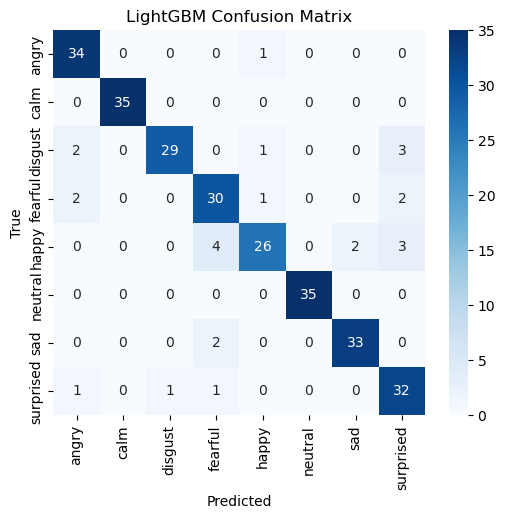


🏆 Best Model: LightGBM (Accuracy 0.91)


In [3]:
import os
import librosa
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import speech_recognition as sr
    SPEECH_RECOGNITION_AVAILABLE = True
except ImportError:
    SPEECH_RECOGNITION_AVAILABLE = False
    print("⚠️ speech_recognition not installed. Falling back to timed recording.")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import time

# -----------------------------
# Step 1: Feature Extraction (enhanced with more features)
# -----------------------------
def extract_features(file, n_mfcc=40, target_sr=48000, min_duration=1.0):  # Use original SR 48kHz, increased features
    try:
        audio, sr = librosa.load(file, sr=target_sr)
        if len(audio) < min_duration * target_sr:
            print(f"⚠️ Skipping short file: {file} (duration < {min_duration}s)")
            return None

        # RMS energy check for cleaning (adjusted threshold)
        rms = librosa.feature.rms(y=audio)
        if np.mean(rms) < 0.005 or np.max(rms) > 0.95:  # Adjusted for better filtering
            print(f"⚠️ Skipping file with invalid RMS: {file} (mean RMS: {np.mean(rms):.4f})")
            return None

        # MFCC + deltas
        mfcc = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=n_mfcc)
        delta1 = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Spectral features
        spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=target_sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=target_sr)
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=target_sr)
        zcr = librosa.feature.zero_crossing_rate(audio)

        # Chroma and contrast
        chroma = librosa.feature.chroma_stft(y=audio, sr=target_sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=target_sr)

        # Additional features: Tonnetz, RMS, Pitch (mean/std)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=target_sr)
        rms_feat = librosa.feature.rms(y=audio)
        f0 = librosa.yin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))  # Pitch estimation

        # Stack all features: mean + std
        feat = np.hstack([
            np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
            np.mean(delta1, axis=1), np.std(delta1, axis=1),
            np.mean(delta2, axis=1), np.std(delta2, axis=1),
            np.mean(spec_centroid), np.std(spec_centroid),
            np.mean(spec_bw), np.std(spec_bw),
            np.mean(rolloff), np.std(rolloff),
            np.mean(zcr), np.std(zcr),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            np.mean(contrast, axis=1), np.std(contrast, axis=1),
            np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1),
            np.mean(rms_feat), np.std(rms_feat),
            np.mean(f0), np.std(f0)
        ])

        if not np.isfinite(feat).all():
            print(f"⚠️ Skipping file with invalid features: {file}")
            return None
        return feat
    except Exception as e:
        print(f"⚠️ Error processing {file}: {e}")
        return None

# -----------------------------
# Step 2: Build Dataset (RAVDESS) - Enhanced cleaning
# -----------------------------
def build_ravdess_dataset(ravdess_dir):
    features, labels = [], []
    emotion_map = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    skipped = 0
    total_files = 0
    for root, _, files in os.walk(ravdess_dir):
        for f in files:
            if f.endswith(".wav"):
                total_files += 1
                parts = f.split("-")
                if len(parts) < 3:
                    skipped += 1
                    continue
                emotion = emotion_map.get(parts[2])
                if not emotion:
                    skipped += 1
                    continue
                file_path = os.path.join(root, f)
                feat = extract_features(file_path)
                if feat is not None:
                    features.append(feat)
                    labels.append(emotion)
                else:
                    skipped += 1
    print(f"🧹 Cleaned dataset: Processed {total_files} files, skipped {skipped}, kept {len(features)}")
    return np.array(features), np.array(labels)

# -----------------------------
# Step 3: Train + Evaluate Models - Simplified for speed and better generalization
# -----------------------------
def train_models(dataset_dir):
    print("🔎 Extracting features...")
    X, y = build_ravdess_dataset(dataset_dir)
    if len(X) == 0:
        raise ValueError("No valid data after cleaning. Check dataset or cleaning thresholds.")
    print(f"✅ Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

    print("Class distribution before balancing:", Counter(y))

    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Balance dataset
    ros = RandomOverSampler(random_state=42)
    X, y_enc = ros.fit_resample(X, y_enc)
    print("Class distribution after balancing:", Counter(y_enc))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Use fixed good params for speed and to avoid poor hyperparam selection
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
        "Logistic Regression": LogisticRegression(C=1, solver="liblinear", max_iter=1000, random_state=42),
        "SVM": SVC(C=1, kernel="rbf", gamma="scale", probability=True, random_state=42),
        "LightGBM": lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\n⚡ Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = (model, acc, scaler)
        print(f"{name} Accuracy: {acc:.2f}")
        print(f"{name} Training Time: {training_time:.2f} seconds")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return results, le

# -----------------------------
# Step 4: Predict Mood with Probability
# -----------------------------
def predict_mood(file, model, le, scaler):
    feat = extract_features(file)
    if feat is None:
        return "⚠️ Could not process file"
    feat = feat.reshape(1, -1)
    feat = scaler.transform(feat)
    pred = model.predict(feat)[0]
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(feat)[0]
        print("Prediction Probabilities:", dict(zip(le.classes_, probs)))
    return le.inverse_transform([pred])[0]

# -----------------------------
# Step 5: Record and Predict - With voice stop or timed fallback
# -----------------------------
def record_and_predict(model, le, scaler, filename="my_voice.wav", max_seconds=30, chunk_duration=2):
    fs = 48000  # Match RAVDESS SR
    if SPEECH_RECOGNITION_AVAILABLE:
        print("🎙 Using voice-activated recording. Say 'stop' to end.")
        recognizer = sr.Recognizer()
        mic = sr.Microphone(sample_rate=fs)
        audio_chunks = []

        with mic as source:
            recognizer.adjust_for_ambient_noise(source)
            print("🎙 Start speaking...")
            start_time = time.time()
            while time.time() - start_time < max_seconds:
                try:
                    audio = recognizer.listen(source, phrase_time_limit=chunk_duration)
                    audio_chunks.append(audio)
                    text = recognizer.recognize_google(audio)
                    print(f"🗣 Heard: {text}")
                    if "stop" in text.lower():
                        print("🛑 'Stop' detected. Ending recording.")
                        if audio_chunks:
                            audio_chunks.pop()  # Remove "stop" chunk
                        break
                except sr.UnknownValueError:
                    pass
                except sr.RequestError as e:
                    print(f"⚠️ Recognition error: {e}. Switching to timed recording.")
                    break
            else:
                print(f"⚠️ Max time ({max_seconds}s) reached. Ending recording.")

        if audio_chunks:
            full_frame_data = b''.join([chunk.frame_data for chunk in audio_chunks])
            sample_rate = audio_chunks[0].sample_rate
            sample_width = audio_chunks[0].sample_width
            full_audio = sr.AudioData(full_frame_data, sample_rate, sample_width)
            with open(filename, "wb") as f:
                f.write(full_audio.get_wav_data())
            print(f"✅ Saved recording to {filename}")
        else:
            print("⚠️ No valid audio recorded.")
            return None
    else:
        print(f"🎙 Recording for {max_seconds} seconds (speech_recognition unavailable)...")
        recording = sd.rec(int(max_seconds * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()
        sf.write(filename, recording, fs)
        print(f"✅ Saved recording to {filename}")

    mood = predict_mood(filename, model, le, scaler)
    print(f"🎯 Predicted Mood: {mood}")
    return mood

# -----------------------------
# 🚀 Example Usage
# -----------------------------
results, le = train_models("Audio_Speech_Actors_01-24")  # Path to RAVDESS dataset

# Pick best model
best_model_name = max(results, key=lambda k: results[k][1])
best_model, best_acc, best_scaler = results[best_model_name]
print(f"\n🏆 Best Model: {best_model_name} (Accuracy {best_acc:.2f})")



In [8]:

record_and_predict(best_model, le, best_scaler)

🎙 Using voice-activated recording. Say 'stop' to end.
🎙 Start speaking...
🗣 Heard: what r u doing
🗣 Heard: Federal staff in the stop
🛑 'Stop' detected. Ending recording.
✅ Saved recording to my_voice.wav
Prediction Probabilities: {np.str_('angry'): np.float64(0.5774309083319471), np.str_('calm'): np.float64(7.339588316573278e-05), np.str_('disgust'): np.float64(0.14169739002569315), np.str_('fearful'): np.float64(0.03350003612175482), np.str_('happy'): np.float64(0.21029849386178687), np.str_('neutral'): np.float64(0.0020136381747154074), np.str_('sad'): np.float64(0.03491922102522092), np.str_('surprised'): np.float64(6.691657571605201e-05)}
🎯 Predicted Mood: angry


D:\anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=760
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


np.str_('angry')